# 隨機森林概述
隨機森林是一種建立在begging上的集成算法，透過建立$M$棵決策樹組合成一座森林，當有新樣本要預測時，分別輸入近這$M$棵決策樹，我們會得到$M$個結果，這時候總結這$M$個結果作為隨機森林的輸出。如果是分類問題，則隨機森林的輸出為$M$個結果中最多數的那個結果；若是回歸問題，輸出通常以$M$個結果的平均作為輸出。
簡而言之，我們只需要理解決策樹的生成算法（sklearn中是採CART算法），可以輕易的推廣到隨機森林中，不過生成森林的過程中仍有部分細節需說明，當中，涉及到許多的隨機性（隨機特徵、隨機抽樣訓練），下方將說明，因此隨機森林某種程度上如同黑盒子，相比單棵決策樹，隨機森林犧牲了部分解釋性換取了更準確或是說更通用的模型。

## Boostrap抽樣
Boostrap是一種抽樣的方法，它的核心是從所有樣本中採有放回式的隨機抽取樣本作為一棵決策樹的訓練集，這表示說每個樣本可能會被抽不只一次，在隨機森林中其目的是增加訓練樣本的隨機性；Boostrap最常見的作法是從$N$個樣本中，以boostrap方式抽取$N$次得到$N$個樣本作為一棵決策樹的訓練樣本，我們可以計算每個樣本在這$N$次都沒被抽到的機率：

$$
\left(1-(\frac{1}{N})\right)^N = \frac{1}{\left(1+\frac{1}{N-1}\right)^N}=P
$$
當N趨近於無限大時，P的結果將會收斂近似於0.368
$$
\lim_{N \to +\infty} P\approx \frac{1}{\exp} =0.368
$$

也就是說，在Boostrap抽取數量等於樣本總數且當樣本足夠大的情況下，我們建立隨機森林時，每建立一棵決策樹都大約有37%的樣本不會被作為訓練樣本。當然，可以依照自身需求來設置Boostrap抽樣數。

### OOB 預測誤差
由於我們在建立隨機森林的過程中，是透過Boostrap抽樣作為每棵樹的訓練樣本，因此每一棵樹都會有部分的樣本不會被拿來訓練，我們稱這些沒有被拿來訓練該棵樹的樣本為OOB(Out Of Beg)樣本，這時候就可以利用這些OOB樣本作為測試集來評估整個隨機森林模型，如同self-validation，其迭代多次（生成夠多棵樹）後的結果會趨向穩定，在理論上就近似於做了k-fold交叉驗證。

在分類問題上，我們可以透過OOB錯誤率來評估模型的好壞，具體作法是：

1. 根據上述，每個樣本$X_i$都會對應到一個屬於它自己的OOB決策樹集合$S_i$，也就是在$S_i$集合當中所有決策樹在訓練過程中都沒有使用到$X_i$樣本來訓練。
2. 而每個$S_i$都能構成一座較小的森林$F_i$，我們可以將每個$X_i$都帶入$F_i$得到一個預測結果，再比較預測結果與樣本真實值間的誤差（分類問題中，若預測錯誤記為1），進一步能計算出OOB錯誤率:
$$
error_{OOB}=\frac{1}{N}\sum_{i=1}^{N}I(y_i \neq F_i(X_i))
$$

OOB錯誤率越小表示模型越好；迴歸問題中，OOB預測誤差常以平方誤差等形式表示。

我們經常使用OOB預測誤差除了其能夠有self-validation的作用外，最重要的是它不必像交叉驗證需要建立多座隨機森林，當我們建立好一座隨機森林的同時，也就已經取得了所有計算OOB預測誤差所需要的元素了，也就已經完成了OOB預測誤差的計算了。

## 特徵隨機性
在隨機森林的建模過程中（生成多棵決策樹的過程），除了樣本具有隨機性（每棵樹的訓練樣本都不同），特徵也是具有隨機性的，具體做法是在每次分枝時，並不會用所有特徵來分枝，只會隨機的選$K$個特徵來分枝，並根據這$K$個特徵的criterion（sklearn中以entropy或gini）來分枝，最終建立出一棵棵的CART決策樹；特別注意，隨機特徵是指在每次分枝時都隨機選取$K$個特徵來分枝，並非同一棵樹都採用固定的$K$個特徵來分枝。特徵隨機性其最主要的目的是讓樹與樹之間的相關性降低，即每一棵樹都是用不同的樣本與不同的特徵生成的，藉此避免overfitting。假設樣本集中總共有$Q$個特徵，一般隨機特徵$K$的數量設定為$\log_{2}Q$或是$\sqrt{Q}$，下方展示二分類問題，在不同決策樹的數量（n_features）下，採用不同數量的隨機特徵（max_features）與OOB錯誤率的關係：

In [10]:
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 1233

# 隨機生成500個樣本，含25個特徵的二分類數據
X, y = make_classification(n_samples=500, n_features=25,
                           n_clusters_per_class=1, n_informative=15,
                           random_state=RANDOM_STATE)
y
X.shape

(500, 25)

In [16]:
# 建立不同max_features隨機森林分類器
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,  # 每次建立決策樹都隨機考慮5個特徵
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features="log2", # 每次建立決策樹都隨機考慮log25個特徵
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None, # 每次建立決策樹都考慮所有特徵
                               oob_score=True,
                               random_state=RANDOM_STATE))
]


RandomForestClassifier, max_features='sqrt' RandomForestClassifier(oob_score=True, random_state=1233, warm_start=True)
RandomForestClassifier, max_features='log2' RandomForestClassifier(max_features='log2', oob_score=True, random_state=1233,
                       warm_start=True)
RandomForestClassifier, max_features=None RandomForestClassifier(max_features=None, oob_score=True, random_state=1233,
                       warm_start=True)


In [19]:
# 建立一個字典包含
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
error_rate["RandomForestClassifier, max_features='sqrt'"]
error_rate

OrderedDict([("RandomForestClassifier, max_features='sqrt'", []),
             ("RandomForestClassifier, max_features='log2'", []),
             ('RandomForestClassifier, max_features=None', [])])

In [20]:
# 設定隨機森林當中決策樹的最大數量與最小數量
min_estimators = 50
max_estimators = 200

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)
		# OOB 錯誤率
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

In [22]:
error_rate["RandomForestClassifier, max_features='sqrt'"]
error_rate

OrderedDict([("RandomForestClassifier, max_features='sqrt'",
              [(50, 0.04800000000000004),
               (51, 0.050000000000000044),
               (52, 0.052000000000000046),
               (53, 0.05400000000000005),
               (54, 0.052000000000000046),
               (55, 0.050000000000000044),
               (56, 0.050000000000000044),
               (57, 0.04600000000000004),
               (58, 0.04600000000000004),
               (59, 0.04400000000000004),
               (60, 0.04200000000000004),
               (61, 0.038000000000000034),
               (62, 0.040000000000000036),
               (63, 0.040000000000000036),
               (64, 0.04800000000000004),
               (65, 0.04400000000000004),
               (66, 0.040000000000000036),
               (67, 0.04400000000000004),
               (68, 0.040000000000000036),
               (69, 0.038000000000000034),
               (70, 0.03600000000000003),
               (71, 0.03200000000000003),
    

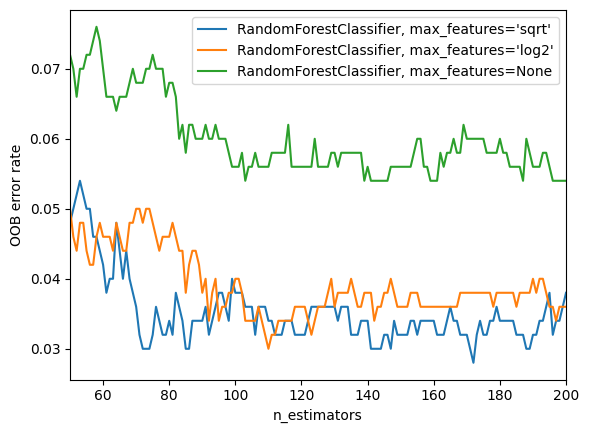

In [24]:
# OOB錯誤率與樹數量間的關係
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

可以發現，當迭代次數夠多之後，OOB錯誤率都趨於穩定，比較隨機特徵數對於預測表現的差異，可以發現採用全部25個特徵所建立出來的隨機森林OOB錯誤率都比$\log_2 25$與$\sqrt{25}$高出許多，這也意味著若我們每次生成樹時，都用全部的特徵去生成，很高的機會會造成overfitting。